# 4G10 Coursework 2: predicting hand kinematics from neural data


Please read carefully the last section of this notebook, which gives some of our expectations regarding your report.

In this handout, 
- <u>text that is underlined</u> corresponds to things you have to do / implement.
- **text in bold** corresponds to questions you need to answer in some form in your report.


In [2]:
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import requests
import random
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import seaborn as sns
np.random.seed(0)
random.seed(1)

# 1. Setup

In this piece of 4G10 coursework, you will use neural data recorded in the primary motor cortex (M1) of a reaching monkey to predict the kinematics of the monkey's hand.

The monkey initiated each trial by placing their hand in the center of a fronto-parallel screen. A target then appeared on the screen. The monkey had to wait for a ‘go’ cue before making a reaching movement towards the instructed target. The targets were placed in various positions in a virtual maze, which changed in each trial, forcing the monkey to make a variety of reaching movements across trials.

The activity of $N=162$ motor cortical neurons was recorded simultaneously, alongside the kinematics of the animal's hand.

In the dataset presented below, all time series are partitioned into trials. Each trial begins at the go cue and lasts 800ms ($T = 16$ bins of 50ms duration) — roughly the duration of a reach. 

In [3]:
# grab the data from the server
r = requests.get('http://4G10.cbl-cambridge.org/data.npz', stream = True)
data = np.load(BytesIO(r.raw.read()))

Among other things (detailed later), this dictionary numerical arrays indexed by the following keys:
- `"hand_train" (2 × 400 × T)`: 2D velocity (X/Y) of the monkey's hand in 400 ‘train’ trials;
- `"neural_train" (N × 400 × T)`: neural activity (spike counts) in the same 400 ‘train’ trials;
- `"neural_test" (N × 100 × T)`: neural activity (spike counts) in 100 ‘test’ trials.

E.g.:

In [4]:
hand_train = data["hand_train"]
hand_train.shape

(2, 400, 16)

The goal of this CW is to implement some of the modelling / decoding techniques you have been taught in lectures, to predict the monkey's 2D hand velocity in the 100 test trials for which you are only given neural activity. Your predictions will be based on the training data provided (`hand_train, neural_train`).

# 2. Baseline decoder: simple Gaussian smoothing + linear regression

To establish a meaningful baseline, you will first implement a very simple two-stage decoder.
In the first stage, you will smooth the spike count time series of each neuron by convolving it with a Gaussian filter of width $\sigma$; in continuous time, such a Gaussian filter is given by $f(t) \propto \exp(-t^2/2\sigma^2)$.

In [5]:
def gaussian_smooth_idx(sigma, data, smoothed_data, shape, idx):
    # Basically, for some t away from a cell, we decide how much to weight that in our observation. So if t=0 (on that observation), weight is maximized at 1 (decays as we move away).
    time_indices = np.arange(shape[2]) # Shape is neurons x trials x time steps
    mask = np.abs(time_indices - idx)
    mask = np.expand_dims(mask, axis=(0, 1)) # Cast over neuron and trial dimensions
    mask = np.broadcast_to(mask, shape)
    mask = np.exp(-(mask**2)/(sigma**2))
    
    # Normalize the mask to ensure it sums to 1 across time dimension
    normalization_factor = np.sum(mask, axis=2, keepdims=True)  # Sum over time steps
    mask = mask / normalization_factor  # Normalize the mask
    
    # Multiply each value of mask by original value and then average
    weighted_data = mask * data
    smoothed_data[:, :, idx] = np.sum(weighted_data, axis = 2) # Sum across weighted time steps

# Test the function
test_array = np.array(
    [[[3, 7],
  [5, 1],
  [0, 9]],
 [[0, 4],
  [7, 3],
  [2, 7],],
 [[2, 0],
  [0, 4],
  [5, 5]]])
test_smoothed_array = np.zeros(test_array.shape)
gaussian_smooth_idx(10, test_array, test_smoothed_array, test_array.shape, 1)
print(test_array, test_smoothed_array)

[[[3 7]
  [5 1]
  [0 9]]

 [[0 4]
  [7 3]
  [2 7]]

 [[2 0]
  [0 4]
  [5 5]]] [[[0.         5.00999992]
  [0.         2.99000008]
  [0.         4.52249981]]

 [[0.         2.00999992]
  [0.         4.99000008]
  [0.         4.5124999 ]]

 [[0.         0.99500004]
  [0.         2.00999992]
  [0.         5.        ]]]


In [6]:
def gaussian_smooth(sigma, data):
    shape = data.shape
    smoothed_data = np.zeros(shape)
    for idx in range(shape[2]): # Iterate over the time bins
        gaussian_smooth_idx(sigma, data, smoothed_data, shape, idx)
    return smoothed_data

In [7]:
# Stage 1: Smoothing spike count using gaussian filter of width sigma
# Kernels say how we take an average with neighboring points. Here, we are using the Gaussian curve to indicate importance of nearby points

# If time bins are width 50 ms, then 0.4 corresponds to 20 ms and 1.3 corresponds to 80 ms
sigma = 1.3 # +/- milliseconds (ms)
neural_train = data["neural_train"]
print(neural_train.shape)

# Container to hold results of smoothing train set
smoothed_neural_train = gaussian_smooth(sigma, neural_train)

# As sigma grows, we move to an unweighted average (more smooth)
# As sigma shrinks we care only about time steps very close (less smooth)
print(smoothed_neural_train.shape)

(162, 400, 16)
(162, 400, 16)


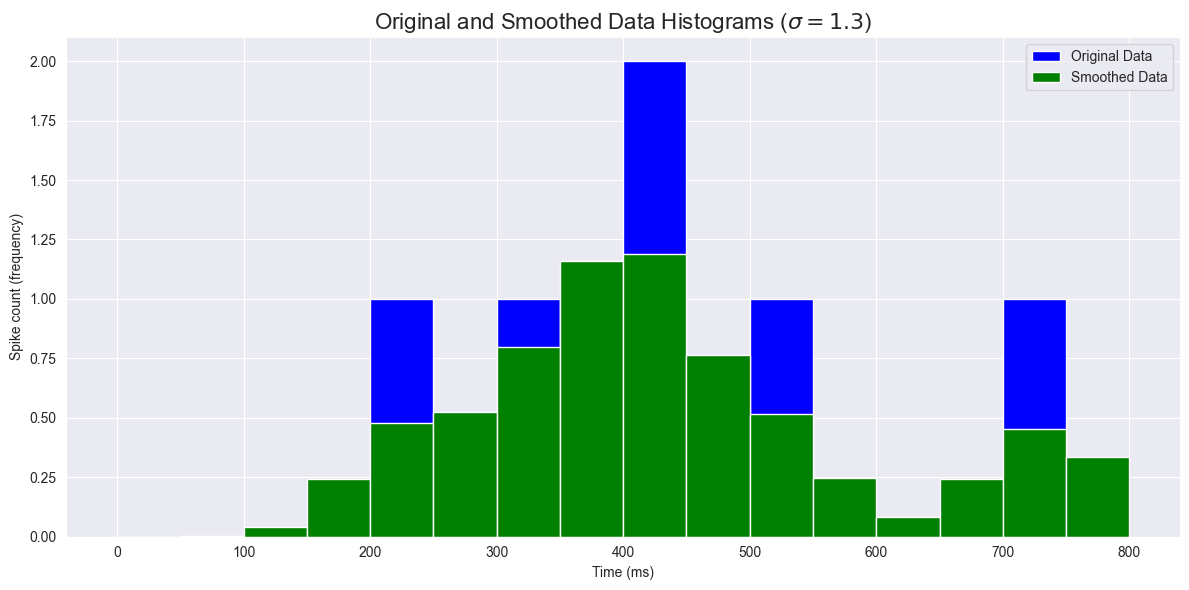

In [8]:
# Let's plot the smoothing for the report
neuron = 2
trial = 0
time_axis = np.arange(0, 751, 50) # Time bins
slice_to_plot = neural_train[neuron, trial, :] # First neuron, first trial, all time bins
smooth_slice_to_plot = smoothed_neural_train[neuron, trial, :] # First neuron, first trial, all time bins

# Combine data with the new dimension
slice_to_plot_2d = np.vstack([time_axis, slice_to_plot])
smooth_slice_to_plot_2d = np.vstack([time_axis, smooth_slice_to_plot])

# Create a single plot
plt.figure(figsize=(12, 6))

# Original data histogram
plt.bar(time_axis, slice_to_plot, width=50, align='edge', color='blue', alpha=1.0, label="Original Data")

# Smoothed data histogram (plotted on top)
plt.bar(time_axis, smooth_slice_to_plot, width=50, align='edge', color='green', alpha=1.0, label="Smoothed Data")

# Titles and labels
plt.title(f"Original and Smoothed Data Histograms ($\\sigma = {sigma}$)", fontsize=16)
plt.xlabel("Time (ms)")
plt.ylabel("Spike count (frequency)")

# Add legend
plt.legend()

# Save the plot as a high DPI image
plt.savefig(f'plots/original_and_smoothed_data_histograms_sigma={sigma}.pdf', dpi=300)  # Save as PNG with 300 DPI for high resolution

# Adjust layout
plt.tight_layout()
plt.show()

In the second stage, you will use ridge regression to learn an instantaneous linear decoder given by

$$ \hat{v}_{k,t} = W \tilde{x}_{k,t} $$

where $\hat{v}_{k, t} \in \mathbb{R}^2$ is the predicted velocity of the hand in test trial $k$ and time bin $t$, $\tilde{x}_{k, t} \in \mathbb{R}^N$ is the $t^\text{th}$ time bin of the temporally smoothed spike counts in test trial $k$, and $W$ is a `2 × N` matrix of decoding weights. Note that the hand velocity data has been centered already, so there is no need to include a bias term in the regression.

The optimal ridge regression weights are given by
$$  W^\star = V \tilde{X}^\top (\tilde{X} \tilde{X}^\top + \lambda I_N )^{-1} $$
where $V$ is the $2 × (400*16)$ matrix of hand velocities from the training set (with all trials and time bins concatenated horizontally), and similarly $\tilde{X}$ is the $N × (400*16)$ matrix of smoothed neural spike counts in the training set.

In the equation above, $\lambda$ is a regularisation parameter which helps protect against overfitting.
The choice of value for this parameter is left up to you, so long as you can provide a justification (there are several sensible possibilities).

The goal here is to make the best possible predictions you can of the held out hand velocity data in test trials, based on the neural activity in the same trials. When you are ready to test your predictions, you can submit them as a 3D numpy array of shape `2 × 100 × 16` to http://4G10.cbl-cambridge.org (note: http, not https). If you get a “HTTP error 400” back, it probably means the format is wrong. Your numpy array must be saved using the `np.save("filename.npy", my_array)` function; the server also expects the array to be of `float64` numerical type — this should be the default in numpy, but if in doubt you can always cast using `my_array.as_type("float64")`. When you submit, please indicate your candidate number and choose "Simple Gaussian smoothing" in the dropdown list. Upon uploading, you will receive immediate feedback in the form of an $R^2$ coefficient. The closer to 1, the better!

In [9]:
def compute_W_star(X, V, l):
    # Why ridge regression? reduce covariance of parameters by increasing diagonal (lambda * I_N) so ratio of variance to covariance is increased
    
    I_N = np.eye(X.shape[0])
    
    V_X_T = np.tensordot(V, X.T, axes=([2, 1], [0, 1]))
    
    X_X_T = np.tensordot(X, X.T, axes=([2, 1], [0, 1]))
    
    inv_mat = np.linalg.inv(X_X_T + l * I_N)
    
    W_star = np.tensordot(V_X_T, inv_mat, axes=([1], [0]))
    
    return W_star

In [10]:
X = smoothed_neural_train
V = hand_train
l = 100

In [11]:
W_star = compute_W_star(X, V, l)

neural_test = data["neural_test"]
test_shape = neural_test.shape

# Container to hold results of smoothing on test set
smoothed_neural_test = np.zeros(test_shape)
for idx in range(test_shape[2]): # Iterate over the time bins
    gaussian_smooth_idx(sigma, neural_test, smoothed_neural_test, test_shape, idx)

V_test = np.tensordot(W_star, smoothed_neural_test, axes=([1],[0]))
print(V_test.shape)

np.save("outputs/V_test.npy", V_test)

(2, 100, 16)


In [89]:
# Use k-fold cross validation to choose lambda
num_folds = 5
fold_size = X.shape[1] / num_folds
ls = [0.1, 1, 10, 100, 1000]

for l in ls:
    fold_r2s = []
    for i in range(num_folds):
        start_idx = int(fold_size * i)
        
        # Figure out current validation indices
        val_indices = np.arange(start_idx, start_idx + fold_size).astype(int)
        
        # Training indices are everything else
        train_indices = np.setdiff1d(np.arange(X.shape[1]), val_indices).astype(int)
        
        # Extract test set (everything else)
        X_train = X[:, train_indices, :]
        X_train_smooth = gaussian_smooth(sigma, X_train)
        X_val = X[:, val_indices, :]
        X_val_smooth = gaussian_smooth(sigma, X_val)
        
        V_train = V[:, train_indices, :]
        V_val = V[:, val_indices, :]
        
        W_star = compute_W_star(X_train, V_train, l)
        V_pred = np.tensordot(W_star, X_val, axes=([1], [0]))
        
        # Compare validation velocities to predicted velocities using R^2 score
        r2 = r2_score(V_val.flatten(), V_pred.flatten())
        fold_r2s.append(r2)
    
    avg_r2 = np.average(np.array(fold_r2s))
    print(f'lambda={l}, avg R^2 across {num_folds} folds: {avg_r2}')

lambda=0.1, avg R^2 across 5 folds: 0.4524728486434225
lambda=1, avg R^2 across 5 folds: 0.4529755502832741
lambda=10, avg R^2 across 5 folds: 0.45632584304887674
lambda=100, avg R^2 across 5 folds: 0.4627272511003403
lambda=1000, avg R^2 across 5 folds: 0.4064102078393132


- <u>Implement Gaussian temporal smoothing + ridge regression as outlined above</u>.
- **How does the quality of hand velocity predictions vary with the smoothing window length $\sigma$? How do you interpret that?** You might want to experiment with values between 20 and 80 ms.
- **Comment on the suitability of this simple decoding strategy for online (“on the fly”) decoding of movement in a BMI context (consider e.g. feasability, computational tractability, and accuracy). Can you think of a small modification to the above approach that would improve applicability to online decoding?** (bonus points for  implementing it!)
- The hand velocity data provided in `data["hand_train"]` had actually been shifted backward by 120ms relative to the neural data (and similarly for the test set, which was not given to you). **Can you speculate about why we did that**?

# 3. Kalman filter-based decoding

We now turn to a more sophisticated decoder based on a Kalman filter/smoother.

### 3.1 An autoregressive prior for hand kinematics

A 10-dimensional linear latent dynamical system (“LDS”; cf lecture notes) was pre-trained for you on the hand velocity data in the training set; specifically, we consider the following generative model:

$$
(1) \qquad z_{k, 0} \sim \mathcal{N}(\mu_0, \Sigma_0) \\ 
(2) \qquad z_{k, t+1} = A z_{k, t} + \epsilon_{k, t+1} \quad \text{with } \epsilon_{k, t+1} \sim \mathcal{N}(0, Q) \\
(3) \qquad v_{k, t} = C z_{k, t} + \eta_{k, t} \quad \text{with } \eta_{k, t} \sim \mathcal{N}(0, R)
$$

where $z_{k, t} \in \mathbb{R}^{10}$ is the latent state in time bin $t$ of trial $k$, and $v_{k, t} \in \mathbb{R}^2$ is the corresponding hand velocity. 

The parameters of this LDS can be found in the same `data` dictionary as above, with the following keys:
- "hand_KF_A" (`10 × 10`): state matrix $A$
- "hand_KF_C" (`2 × 10`): output matrix $C$
- "hand_KF_mu0" (`10 × 1`): initial prior mean $\mu_0$
- "hand_KF_Sigma0" (`10 × 10`): initial prior covariance $\Sigma_0$
- "hand_KF_Q" (`10 × 10`): process noise covariance matrix $Q$
- "hand_KF_R" (`2 × 2`): observation noise covariance matrix $R$

<u>Write your own Kalman smoother implementation and use it to compute the mean $\hat{z}_{k, 1:T}$ of the smoothing distribution $p(z_{k, t} | v_{k, 1:T})$, for each trial $k$ in the training set.</u>


In [90]:
# Pull in the data 
A = data["hand_KF_A"]
C = data["hand_KF_C"]
mu0 = data["hand_KF_mu0"]
Sigma0 = data["hand_KF_Sigma0"]
Q = data["hand_KF_Q"]
R = data["hand_KF_R"]

In [122]:
# Smooth the data with a Kalman smoother
neural_train = data["neural_train"] # Fresh copy of data
N, K, T = neural_train.shape # Shape is neurons (n) x trials (k) x times (t)
LDS_dim = 10

In [131]:
# First, perform Kalman filtering

# Create arrays to hold intermediate values for both mu and Sigma
mu_array = np.zeros(shape=(K, T, LDS_dim))
mu0_repeat = np.repeat(mu0, K, axis=1).T
mu_array[:, 0, :] = mu0_repeat

Sigma_array = np.zeros(shape=(T, LDS_dim, LDS_dim)) # Condition independent
Sigma_array[0] = Sigma0[np.newaxis, :, :]

for t in range(1, neural_train.shape[2]):
    # First, find Sigma t using Sigma t-1    
    C_T_R_1_C = np.matmul(np.matmul(C.T, np.linalg.inv(R)), C)
    A_Sigma_A_T = np.matmul(np.matmul(A, Sigma_array[(t-1)]), A.T)
    Q_Q_T = np.matmul(Q, Q.T)
    Sigma_inv = C_T_R_1_C + np.linalg.inv(A_Sigma_A_T + Q_Q_T)
    
    # Update the next Sigma at time t
    Sigma_array[t] = np.linalg.inv(Sigma_inv)
    
    # Now, use Sigma t to find mu t
    v_t = hand_train[:, :, t] # Use the current velocity at time t to update the hidden state at time t
    C_A = np.matmul(C, A)
    C_A_mu = np.matmul(C_A, mu_array[:, (t-1), :].T)    
    pred_error = v_t - C_A_mu
    assert pred_error.shape == (2,400), 'Shape of prediction error array should be 2 (x & y velocities) by K.'
    
    kalman_gain = np.matmul(np.matmul(Sigma_array[t], C.T), np.linalg.inv(R))
    correction = np.matmul(kalman_gain, pred_error).T # Just because we want conditions by 10
    assert correction.shape == (400, 10), 'Shape of correction should be K by 10 (model trained with 10 params for mu)'
    
    # Update the next mu at time t
    A_mu_t = np.matmul(A, mu_array[:, (t-1), :].T).T # Shape is conditions (K) by time (T)
    assert A_mu_t.shape == (400, 10), 'Shape of A x mu_t should be K by 10 (model trained with 10 params for mu)'

    mu_array[:, t] = A_mu_t + correction

print(f'mu array shape: {mu_array.shape}, Sigma array shape: {Sigma_array.shape}')

mu array shape: (400, 16, 10), Sigma array shape: (16, 10, 10)


In [132]:
# Second, do a backward pass to perform Kalman smoothing 

# Create arrays to hold intermediate values again
mu_array_tilde = np.zeros(shape = mu_array.shape)
Sigma_array_tilde = np.zeros(shape = Sigma_array.shape)

# Populate the last element in both arrays with the last element in mu array and Sigma array
mu_array_tilde[:, T-1] = mu_array[:, T-1]
Sigma_array_tilde[T-1] = Sigma_array[T-1]
print(Sigma_array_tilde)

for t in range(T-2, -1, -1): # 
    A_Sigma_A_T = np.matmul(np.matmul(A, Sigma_array[t]), A.T)
    Q_Q_T = np.matmul(Q, Q.T)
    P_t = A_Sigma_A_T + Q_Q_T
    P_t_inv = np.linalg.inv(P_t)
    G_t = np.matmul(np.matmul(Sigma_array[t], A.T), P_t_inv)
    
    A_mu_t = np.matmul(A, mu_array[:, t].T).T # Use current time
    # print(f'A x mu t shape: {A_mu_t.shape}')
    # print(f'mu tilde t+1 shape: {mu_array_tilde[:, t+1].shape}')
    mu_array_tilde[:, t] = mu_array[:, t] + np.matmul(G_t, (mu_array_tilde[:, t+1] - A_mu_t).T).T
    
    diff = Sigma_array_tilde[t+1] - P_t
    G_t_diff_G_t_T = np.matmul(G_t, np.matmul(diff, G_t.T))
    Sigma_array_tilde[t] = Sigma_array[t] + G_t_diff_G_t_T

print(Sigma_array_tilde)

# Second, do a backward pass to perform Kalman smoothing 

# Create arrays to hold intermediate values again
mu_array_tilde = np.zeros(shape=mu_array.shape)
Sigma_array_tilde = np.zeros(shape=Sigma_array.shape)

# Populate the last element in both arrays with the last element in mu array and Sigma array
mu_array_tilde[:, T - 1] = mu_array[:, T - 1]
Sigma_array_tilde[T - 1] = Sigma_array[T - 1]
print(Sigma_array_tilde)

for t in range(T - 2, -1, -1):  # 
    A_Sigma_A_T = np.matmul(np.matmul(A, Sigma_array[t]), A.T)
    Q_Q_T = np.matmul(Q, Q.T)
    P_t = A_Sigma_A_T + Q_Q_T
    P_t_inv = np.linalg.inv(P_t)
    G_t = np.matmul(np.matmul(Sigma_array[t], A.T), P_t_inv)

    A_mu_t = np.matmul(A, mu_array[:, t].T).T  # Use current time
    # print(f'A x mu t shape: {A_mu_t.shape}')
    # print(f'mu tilde t+1 shape: {mu_array_tilde[:, t+1].shape}')
    mu_array_tilde[:, t] = mu_array[:, t] + np.matmul(G_t, (mu_array_tilde[:, t + 1] - A_mu_t).T).T

    diff = Sigma_array_tilde[t + 1] - P_t
    G_t_diff_G_t_T = np.matmul(G_t, np.matmul(diff, G_t.T))
    Sigma_array_tilde[t] = Sigma_array[t] + G_t_diff_G_t_T

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.   

In [137]:
# Finally, average over all time steps
print(f'mu array tilde shape: {mu_array_tilde.shape}') # Should be K x T x 10
avg_smooth = np.average(mu_array_tilde, axis = 1)
print(f'avg across time mu array tilde shape: {avg_smooth.shape}') # Should be K by 10
# Note that the covariance matrices are already independent of which condition we consider

mu array tilde shape: (400, 16, 10)
avg across time mu array tilde shape: (400, 10)


### 3.2 Building an LDS model of neural data using supervised learning

Conceptually, the latents $z_{k, 1:T}$ introduced above contain signals related to the velocity of the hand, its acceleration, and potentially higher-order derivatives too — all signals which we have good reasons to suspect that neural activity in M1 is strongly related to. Eqs (1) and (2) above provide a good autoregressive prior model for the temporal dynamics of these signals, and you are now going to use this prior in a generative LDS model of _neural data_, substituting the hand-related likelihood (Eq 3) with a neural likelihood:

$$
(4) \qquad x_{k, t} = D z_{k, t} + \xi_{k, t} \quad \text{with } \xi_{k, t} \sim \mathcal{N}(0, S)
$$

where $x_{k, t}$ denotes neural spike counts in the $t^\text{th}$ time bin of trial $k$.

The combination of Eqs (1), (2) and (4) forms an LDS model which you will be able to invert using Kalman filtering to obtain a filtered posterior $p(z_{k', t} | x_{k', 0:t})$ for any test trial $k'$. From there, you will use Eq. (3) to obtain a filtered predictive distribution for the hand velocity in each test trial, $p(v_{k', t} | x_{k', 0:t})$.

- <u>Begin by centering the neural data (both training and testing sets) by removing, for each neuron, its mean activity across both trials and time in the training set.</u>
- <u>Fit the likelihood parameters $D$ and $S$ through supervised learning, by maximizing the joint log-likelihood $\log p(\hat{z}_{k, 1:T}, x_{k, 1:T})$ averaged over all trials in the training set, where $\hat{z}_{k,1:T}$ is the posterior mean you obtained in Section 3.1.</u>
To do this, write down the average joint log likelihood and **show that it is maximized by the following parameter settings**:
    - $ \displaystyle D^\star = \left(\sum_{k, t} x_{k, t} \hat{z}_{k, t}^\top \right) \left( \sum_{k, t} \hat{z}_{k, t} \hat{z}_{k, t}^\top \right)^{-1} $
    - $ \displaystyle S^\star = \frac{1}{KT} \left( \sum_{k, t} x_{k, t} x_{k, t}^\top - D^\star \sum_{k, t} \hat{z}_{k, t} x_{k, t}^\top \right) $ where $K$ is the number of trials in the training set. **Include your derivations in your report.**

In [154]:
# First, center the data by subtracted out the mean wrt condition and time
X_uncentered = data['neural_train'] 
X_avg_cond_time = np.average(X_uncentered, axis = [1, 2])
X_avg_cond_time = X_avg_cond_time[:, np.newaxis, np.newaxis]
X = X_uncentered - X_avg_cond_time

Z_post = mu_array_tilde # Posterior of the values
print(X.shape, Z_post.shape)

(162, 400, 16) (400, 16, 10)


In [157]:
# Now, find D* and S* using the parameter settings defined above
sum_1 = np.zeros(shape = (N, LDS_dim))
sum_2 = np.zeros(shape = (LDS_dim, LDS_dim))
sum_3 = np.zeros(shape = (N, N))
sum_4 = np.zeros(shape = (LDS_dim, N))

for k in range(K):
    for t in range(T):
        x_k_t = (X[:, k, t])[:, np.newaxis] # Dimension should be N x 1
        z_k_t = (Z_post[k, t])[:, np.newaxis] # Dimension should be 10 x 1
        
        sum_1 += np.matmul(x_k_t, z_k_t.T)
        sum_2 += np.matmul(z_k_t, z_k_t.T)
        sum_3 += np.matmul(x_k_t, x_k_t.T)
        sum_4 += np.matmul(z_k_t, x_k_t.T)
        
D_star = np.matmul(sum_1, np.linalg.inv(sum_2))
S_star = (1/(K*T)) * (sum_3 - np.matmul(D_star, sum_4))
print(D_star.shape, S_star.shape)

(162, 10) (162, 162)


### 3.3 Using Kalman filtering to predict the hand velocity

- Based on the model obtained in Section 3.2, <u>write your own Kalman filter implementation and compute the filtered posterior $p(z_{k', t} | x_{k', 0:t}) $ for each trial $k'$ in the test set.</u> What we are really interested in is the mean $\bar{z}_{k', t}$ of this filtered posterior, as our best prediction of the momentary hand velocity $v_{k', t}$ is then given by $\hat{v}_{k', t} = C \bar{z}_{k', t}$.
- <u>Submit your predictions to http://4G10.cbl-cambridge.org (note: http, not https) in the same format as described in Section 2. Please select "Kalman filtering" in the dropdown list. Once again, you will receive immediate feedback in the form of an $R^2$ coefficient.</u> **Include this result in your report, and discuss; in particular, why do you think these predictions are much better than those of Section 2?**
- As in Section 2, **comment on the suitability of this more sophisticated decoding strategy for online decoding of movement in a BCI context**.
- Finally, **what approach(es) would you suggest to improve decoding performance even further? Include a discussion of the tradeoffs that would arise with these alternative approaches.** (max 1 page in your report)

# Writing up


Please write up your findings in a report to be submitted on Moodle in PDF format, and **include all your code in the Appendix**. Please clearly include your candidate number, NOT your name, on the front page. Your report should address all the questions raised in this notebook, be structured around the Sections of this notebook, and **be a maximum of five A4 pages** excluding any Appendix (minimum font size 11pt, minimum margins 1.5cm on each side).

You are very much encouraged to think of data/results visualisations to best support the exposition of your results. You are also encouraged to report on any specific problems/difficulties that arose in your implementation of the various algorithms, and how you addressed those.